# <b>Wikipedia Article Recommendation system


Authors:
- Martyna Stasiak id.156071
- Maria Musiał id.156062

----

### <b>Introduction</b>
The aim of this project is to implement a recommendation system to suggest similiar Wikipedia articles based on the ones that user have seen - user's history. <br>
The system first creates a database containing <b>1000</b> wikipedia articles by crawling starting from the link provided by the user, then preprocesses them and computes similarities to generate miningful and reliable recommendations.

#### <b>Objectives</b>
1. <b>Crawling and Scraping</b>> - collect at least a 1000 Wikipedia articles 
2. <b>Preprocessing</b> - process and clean the data so that it will be suitable for the recommendation, including stemming, lemmatization
3. <b>Similaries</b> - compute the similarities between articles in user's history and in the database
4. <b>Recomendations</b> - recommend the best matching articles to the ones in the user's history 
<br> <br>
---------

Libraries used in this project:

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, wordpunct_tokenize

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

import re
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import cosine

from IPython.core.display import display, HTML

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mmart\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mmart\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mmart\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\mmart\AppData\Local\Temp\ipykernel_28176\1868813398.py:21: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


### <b>Crawling and saving our articles</b>
In this part the csv file is created. It will work as a database containing wikipedia articles that may be recommended to the user.<br><br>
It is done by crawling, that starts from some given URL; here we have chosen https://en.wikipedia.org/wiki/Machine_learning that is the article about Machine Learning. However it might be simply changed by providing a different link while invoking the function.<br><br>
The `crawlArticles` function systematically collects articles by 'jumping' links found on Wikipedia pages. <br><br>
<b>It fetches the title, link, and main content</b> of each article while filtering out irrelevant or special pages (like, disambiguation pages, main page, and links with special characters like ':'). <br><br>
The function stores this information in a structured way, ensuring no duplicate visits, and includes a delay between requests to avoid overloading the server as it is requested by Wikipedia.<br><br> 
A couple of cells below the collected articles are saved as a CSV file, using custom saving function that is used throughout the project, forming our base dataset for the recommendations.

In [2]:
def crawlArticles(start_url, max_articles):
    visited = set() # set of visited pages to keep the ones that have already been crawled
    to_visit = [start_url] # a list of pages yet to be crawled, starting with the start_url
    articles = [] # a list to store the details of the articles (title, link and content)
    
    # a loop to check if there are pages to visit and if the number of articles is less than the max_articles
    while to_visit and len(articles) < max_articles:
        page = to_visit.pop(0) # get the first page in the list
        if page in visited:
            continue
        visited.add(page) # add the page to the visited set
        
        try:
            response = requests.get(page) # geting the page
            response.raise_for_status() 
            soup = BeautifulSoup(response.content, 'html.parser') # parsing the page
            
            # extracting the title and content of the article
            title = soup.find('h1').text # article's title
            paragraphs = soup.find_all('p') # article's paragraphs
            content = ' '.join([p.text for p in paragraphs]) # article's content that is inside paragraphs
            articles.append({"title": title, "link": page, "content": content})
            
            # extracting and filtering new links
            for link in soup.find_all('a', href=True): # we look for all links in the page
                href = link['href']
                # we ensure that no page that has parts like 'disambiguation' or is a 'Main_Page' would be visited and added to the database
                if href.startswith('/wiki/') and ':' not in href and '#' not in href and 'Main_Page' not in href and 'disambiguation' not in href:
                    full_url = "https://en.wikipedia.org" + href
                    if full_url not in visited:
                        to_visit.append(full_url) # adding the new link to the list of pages to visit
                        
            time.sleep(0.5) # need to be polite to Wikipedia
            
        except:
            pass
        
    return articles

In [3]:
articles = crawlArticles("https://en.wikipedia.org/wiki/Machine_learning", 1000)
df = pd.DataFrame(articles)

In [4]:
def saveDatabase(df, fileName):
    df.to_csv(fileName, index=False)
    return None

In [5]:
saveDatabase(df, 'articles.csv')

Here we may see the first five articles (their title, link and content not yet processed) that are in our database:

In [6]:
df.head()

,title,link,content
0,Machine learning,https://en.wikipedia.org/wiki/Machine_learning,Machine learning (ML) is a field of study in a...
1,Machine Learning (journal),https://en.wikipedia.org/wiki/Machine_Learning...,Machine Learning is a peer-reviewed scientifi...
2,Statistical learning in language acquisition,https://en.wikipedia.org/wiki/Statistical_lear...,Statistical learning is the ability for humans...
3,Data mining,https://en.wikipedia.org/wiki/Data_mining,Data mining is the process of extracting and d...
4,Supervised learning,https://en.wikipedia.org/wiki/Supervised_learning,"In machine learning, supervised learning (SL) ..."


In [49]:
print(f"Number of articles in the starting database: {len(df)}")

Number of articles in the starting database: 100


---------

### <b>Preprocessing the Articles</b>
In this step, we preprocess the articles to prepare them for the actual recommendation system. <br><br>
Preprocessing ensures that the articles content is suitable for analysis, making comparisons between articles more meaningful. <br>The processed data is saved to the csv file.<br><br>


We have created a function where the following techniques may be selected:

1. Tokenization: It splits the text into individual words - tokens for further processing.<br>
The tokenizers we chose are:
    - word_tokenize,
    - wordpunct_tokenize.
When performing the preprocessing part it is possible to chose either of them, putting their name as a tokenizer parameter.
2. Removing Stopwords: Stopwords like "the," "is," and "and" are the words that add little or no value to the analysis since they are so common. Removing them helps focus on the more informative parts of the text.
3. Stemming: It reduces words to their root form, usually by chopping off the ends of the words (for example, "automatic" becomes "automat"). Stemming is computationally efficient but can sometimes produce non-standard roots.<br>
Stemmer that we chose:
    - Porter Stemmer,
    - Lancaster Stemmer.
Here same as in the tokenization the specific stemmer might be chosen, putting its name as a stemmer parameter. If we would like to use the stemming we have to provide stemmer's name since by the default there is none.<br>
Also since the results given by the different stemmers may (and will) differ it is important to use the same one throught the preprocessing, for example when preprocessing the new article that is not in the database.
4. Lemmatization: It is generally similar to stemming but ensures the root form is a valid word - it performs a proper reduction of a word to its dictionary form, i.e. lemma (for example, "better" becomes "good"). This is slightly more accurate but computationally intensive.<br>
We chose the WordNet Lemmatizer. Here same as in the stemming case, we have to specify if we would like to use the lemmatizer since by the default function does not use it. Additionaly there is an extra parameter that we have to set to True if we want to use lemmatization.
5. Lowercasing and Removing Non-Alphabetic Characters: Standardizing the text to lowercase and excluding numbers, punctuation, and special characters just to ensure consistency.

In [7]:
stopWords = set(stopwords.words('english'))
porter = PorterStemmer()
lancaster = LancasterStemmer()
lemmatizer = WordNetLemmatizer()

In [8]:
def preprocessArticles(df, tokenizer=word_tokenize, stemmer=None, lemmatizer=None, useLemmatizer=False):
    tokens = tokenizer(df['content'].lower())
    terms = [word for word in tokens if word.isalpha() and word not in stopWords] # remove stopwords and non-alphabetic words
    if stemmer:
        processed = [stemmer.stem(word) for word in terms]
    elif useLemmatizer and lemmatizer:
        processed = [lemmatizer.lemmatize(word) for word in terms]
    else:
        processed = terms
    return ' '.join(processed)
    

Here to compare the different text processing techniques we have displayed processed content of first five articles (in much shortened versions) just to see how they actually differ.

In [9]:
# Define preprocessing variations
variations_wordtokenizer = {
    "porter_stemmer": lambda row: preprocessArticles(row, tokenizer=word_tokenize, stemmer=porter),
    "lancaster_stemmer": lambda row: preprocessArticles(row, tokenizer=word_tokenize, stemmer=lancaster),
    "lemmatization": lambda row: preprocessArticles(row, tokenizer=word_tokenize, lemmatizer=lemmatizer, useLemmatizer=True)
}

# Apply variations without modifying the original DataFrame
results_wordtokenizer = pd.DataFrame({
    "title": df["title"],
    "original_content": df["content"]
})

for name, preprocess_function in variations_wordtokenizer.items():
    # Apply each variation to the content column using the original function
    results_wordtokenizer[name] = df.apply(preprocess_function, axis=1)


variations_wordpunct = {
    "porter_stemmer": lambda row: preprocessArticles(row, tokenizer=wordpunct_tokenize, stemmer=porter),
    "lancaster_stemmer": lambda row: preprocessArticles(row, tokenizer=wordpunct_tokenize, stemmer=lancaster),
    "lemmatization": lambda row: preprocessArticles(row, tokenizer=wordpunct_tokenize, lemmatizer=lemmatizer, useLemmatizer=True)
}

# Apply variations without modifying the original DataFrame
results_wordpunct = pd.DataFrame({
    "title": df["title"],
    "original_content": df["content"]
})

for name, preprocess_function in variations_wordpunct.items():
    # Apply each variation to the content column using the original function
    results_wordpunct[name] = df.apply(preprocess_function, axis=1)


In [10]:
print("Word Tokenizer")
columns_to_display = ["title", "original_content"] + list(variations_wordtokenizer.keys())
results_wordtokenizer[columns_to_display].head()

Word Tokenizer


,title,original_content,porter_stemmer,lancaster_stemmer,lemmatization
0,Machine learning,Machine learning (ML) is a field of study in a...,machin learn ml field studi artifici intellig ...,machin learn ml field study art intellig conce...,machine learning ml field study artificial int...
1,Machine Learning (journal),Machine Learning is a peer-reviewed scientifi...,machin learn scientif journal publish sinc for...,machin learn sci journ publ sint forty edit me...,machine learning scientific journal published ...
2,Statistical learning in language acquisition,Statistical learning is the ability for humans...,statist learn abil human anim extract statist ...,stat learn abl hum anim extract stat regul wor...,statistical learning ability human animal extr...
3,Data mining,Data mining is the process of extracting and d...,data mine process extract discov pattern larg ...,dat min process extract discov pattern larg da...,data mining process extracting discovering pat...
4,Supervised learning,"In machine learning, supervised learning (SL) ...",machin learn supervis learn sl paradigm model ...,machin learn superv learn sl paradigm model tr...,machine learning supervised learning sl paradi...


In [11]:
print("Word Punct Tokenizer")
columns_to_display = ["title", "original_content"] + list(variations_wordpunct.keys())
results_wordpunct[columns_to_display].head()

Word Punct Tokenizer


,title,original_content,porter_stemmer,lancaster_stemmer,lemmatization
0,Machine learning,Machine learning (ML) is a field of study in a...,machin learn ml field studi artifici intellig ...,machin learn ml field study art intellig conce...,machine learning ml field study artificial int...
1,Machine Learning (journal),Machine Learning is a peer-reviewed scientifi...,machin learn scientif journal publish sinc for...,machin learn sci journ publ sint forty edit me...,machine learning scientific journal published ...
2,Statistical learning in language acquisition,Statistical learning is the ability for humans...,statist learn abil human anim extract statist ...,stat learn abl hum anim extract stat regul wor...,statistical learning ability human animal extr...
3,Data mining,Data mining is the process of extracting and d...,data mine process extract discov pattern larg ...,dat min process extract discov pattern larg da...,data mining process extracting discovering pat...
4,Supervised learning,"In machine learning, supervised learning (SL) ...",machin learn supervis learn sl paradigm model ...,machin learn superv learn sl paradigm model tr...,machine learning supervised learning sl paradi...


<b>Since the lemmatization is more exhaustive we have chose to use the stemming with Porter's algorithm and a word_tokenizer.</b>
However it is easy to change to a different method, just by adjusting the parameters. The processed data is now saved to the processedArticles.csv file, that has one more column than the articles.csv (or any different database that was provided) - processedContent that contains as the name suggests the processed content of the article.

In [12]:
df['processedContent'] = df.apply(lambda row: preprocessArticles(row, tokenizer=word_tokenize, stemmer=porter, 
                                                          lemmatizer=None, useLemmatizer=False), axis=1)
saveDatabase(df, 'processedArticles.csv')

columnstoUse = ['title', 'content','processedContent']
df[columnstoUse].head()

,title,content,processedContent
0,Machine learning,Machine learning (ML) is a field of study in a...,machin learn ml field studi artifici intellig ...
1,Machine Learning (journal),Machine Learning is a peer-reviewed scientifi...,machin learn scientif journal publish sinc for...
2,Statistical learning in language acquisition,Statistical learning is the ability for humans...,statist learn abil human anim extract statist ...
3,Data mining,Data mining is the process of extracting and d...,data mine process extract discov pattern larg ...
4,Supervised learning,"In machine learning, supervised learning (SL) ...",machin learn supervis learn sl paradigm model ...


-----------

### <b>Term Frequency-Inverse Document Frequency Vectorization</b>
In this part, we transform the preprocessed articles into numerical vectors using TF-IDF vectorization, that is Term Frequency-Inverse Document Frequency. <br><br>
TF-IDF is a weighting scheme that is the best konown and most commonly used in the Information Retrieval field.<br>
It quantifies the importance of a term in specific document or like in this case article relative to its importance in the entire corpus.<br><br>
TF-IDF is composed of two parts:
- Term Frequency (TF): Measures how frequently given term appears in the document or articte,
- Inverse Domain Frequency (IDF): It reduces the importance of commonly occuring terms across the whole corpus and at the same time emphasizing the ones that are distinctive.

In [13]:
def tf_idf(df):
    tfidf = TfidfVectorizer(use_idf=True, smooth_idf=False)
    tfidf_matrix = tfidf.fit_transform(df['processedContent'])

    dfTFIDF = pd.DataFrame(tfidf_matrix.toarray(), index=df['title'], columns=tfidf.get_feature_names_out())
    return tfidf, dfTFIDF


In [14]:
tfidf, dfTFIDF = tf_idf(df)

dfTFIDF.head()

,aae,aahc,aapo,ab,abandon,abbeel,abbrevi,abil,abl,abnorm,...,βk,βότρυς,εi,θi,λnm,λx,μi,μs,σi,σλi
title,,,,,,,,,,,,,,,,,,,,,
Machine learning,0.0,0.00000,0.0,0.0,0.008804,0.0,0.0,0.009023,0.007688,0.009596,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Machine Learning (journal),0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Statistical learning in language acquisition,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.049704,0.098814,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Data mining,0.0,0.01912,0.0,0.0,0.000000,0.0,0.0,0.007877,0.013423,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Supervised learning,0.0,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.054929,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


------

## <b>Recommendation System</b> 
This section is  the `core` part of the recommendation system .<br>
It uses all the methods defined and explained above, that is:  
1. <b>Crawling</b>: to get the database of the articles avileable for recomendation, 
2. <b>Processing</b> of the article's content to work with the meaningful text, 
3. <b>TF-IDF vectorization</b> to get the importance of each term artice wise.<br><br>

#### How it works
The recommendation system takes the user's history (a list of titles the user has read or liked) and the article database as input and outputs the top_n recommendations – the articles most similar to the user's history.<br><br>
To get the most meaningful recommendations recommender uses the cosine similarity.<br>
It measures the angle between two vectors in high dimentional space; a smaller angle, that is closer to 1, means higher similarity.
<br><br>
The system fetches content of the articles that are in the user's history from the articles database and transforms it to a vector representation using the TF-IDF vectorization. Next it calculates the cosine similarity between the history vector and each of the articles in the database and returns the ones that are mostly similiar to the user's history, at the same time ensuring that no article from it will be in the recommendations.<br><br>
The output has top_n rows corresponding to the top_n recommendations - the most similiar articles to the user's history, and 3 columns representing article's:
- Title,
- Link - a clickable link that redirects us directly to the recommended article (note that the url might differ from the article name, but on the Wikipedia website the article corresponds to the title),
- Similarity score between given article and user's history.

In [15]:
def recommendArticles(history, df, top_n=5):
    
    if df.index.name != 'title':
        df = df.set_index('title')
    
    tfidf, dfTFIDF = tf_idf(df.reset_index())

    
    
    historyContent = ' '.join(df.loc[history,'processedContent'])
    historyVector = tfidf.transform([historyContent]).toarray()[0]
    
    cosineDistance = dfTFIDF.apply(lambda row: cosine(row, historyVector), axis=1)
    similarityScores = 1 - cosineDistance
    
    recommendations = pd.DataFrame({
        'title': dfTFIDF.index, 
        'link': df['link'],
        'similarity': similarityScores
    })
    
    # we exclude the articles that user have already seen from the recommendations
    recommendations = recommendations[~recommendations['title'].isin(history)]
    
    recommendations = recommendations.sort_values(by='similarity', ascending=False).reset_index(drop=True)
    
    recommendations = recommendations.head(top_n)

    
    recommendations = HTML(recommendations.to_html(render_links=True, escape=False))
    
    return recommendations

In [16]:
history = ['Machine learning']


recommendations = recommendArticles(history, df, top_n=5)
recommendations

,title,link,similarity
0,Deep learning,https://en.wikipedia.org/wiki/Deep_learning,0.529736
1,Neural network (machine learning),https://en.wikipedia.org/wiki/Artificial_neural_network,0.528905
2,Meta-learning (computer science),https://en.wikipedia.org/wiki/Meta-learning_(computer_science),0.521394
3,Self-supervised learning,https://en.wikipedia.org/wiki/Self-supervised_learning,0.492130
4,Feature learning,https://en.wikipedia.org/wiki/Feature_learning,0.489661


In [17]:
history = ['Machine learning', 'Supervised learning']


recommendations = recommendArticles(history, df, top_n=5)
recommendations

,title,link,similarity
0,Meta-learning (computer science),https://en.wikipedia.org/wiki/Meta-learning_(computer_science),0.546825
1,Neural network (machine learning),https://en.wikipedia.org/wiki/Artificial_neural_network,0.527768
2,Deep learning,https://en.wikipedia.org/wiki/Deep_learning,0.521364
3,Self-supervised learning,https://en.wikipedia.org/wiki/Self-supervised_learning,0.511088
4,Feature learning,https://en.wikipedia.org/wiki/Feature_learning,0.503922


----------------

### <b>Adding articles in user history that are not in the database</b>
Since the Wikipedia has more than 6 million English articles we may encounter the situation that the user has seen the article that is not in our rather small database; <br>
To addres this, we implemented a dynamic mechanism to handle such cases by fetching, processing, and expanding the database with new articles.
#### Steps for adding a new article
1. Fetch Article:<br>
The fetchUnknownArticle function takes the title of the unknown article as input. It constructs the article's URL using the Wikipedia structure and fetches its content by making an HTTP request.
    - The function extracts the title, link, and content of the article.
    - The content is processed using the preprocessArticles function to generate a processedContent field.

2. Expand with Related Articles <br>
The additionalArticles function is invoked for the newly fetched article. This function uses the article's link as the starting point for crawling additional related articles.

    - Newly crawled articles are filtered to ensure they aren't already in the database.
    - Each article is processed (tokenized, stemmed/lemmatized) and added to the list of new articles.

3. Update the Database
The expandDatabase function consolidates the newly fetched articles (both the original and the crawled ones) and appends them to the existing database.

    - The database is updated dynamically to include these new articles, ensuring no duplicates are introduced.
    - The updated database is saved to the CSV file, ensuring persistence for future recommendations.

----

When the recommendation system is invoked:

The user's history is examined to identify titles that are missing from the database.
Missing articles are fetched, processed, and added to the database through the steps above.
The expanded database is then used to generate recommendations, ensuring the system remains robust and comprehensive, even with articles outside the original dataset.



In [18]:
# history = ['Machine learning', 'Aliens']
# recommendations = recommendArticles(history, df, top_n=5)
# recommendations

In [19]:
df = pd.read_csv('processedArticles.csv')

In [20]:
def fetchUnknownArticle(unknowTitle):
    base_url = "https://en.wikipedia.org/wiki/"
    url = base_url + unknowTitle.replace(' ', '_')
    
    try:
        response = requests.get(url)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, 'html.parser')
        
        paragraphs = soup.find_all('p')
        content = ' '.join([p.text for p in paragraphs if p.text])
        
        #to preprocess the content we simulate dataframe row
        row = pd.Series({"content": content})
        
        processedArticle = preprocessArticles(row, tokenizer=word_tokenize, stemmer=porter, 
                                                          lemmatizer=None, useLemmatizer=False)
        
        
        newArticle = {"title": unknowTitle, "link": url, "content": content, 
                      "processedContent": processedArticle}
        return newArticle
    except:
        print(f"Failed to fetch article {unknowTitle}. Please check the title and try again.")

In [21]:
def additionalArticles(newArticle, df, maxExpansion=5):
    mainArticle = fetchUnknownArticle(newArticle)
    if mainArticle is None:
        return []
    
    newCrawledArticles = crawlArticles(mainArticle['link'], max_articles=maxExpansion)
    
    processedNewArticles=[]
    for article in newCrawledArticles:
        if article['title'] not in df['title'].values:
            row = pd.Series({"content": article['content']})
            article['processedContent'] = preprocessArticles(row, tokenizer=word_tokenize, stemmer=porter, 
                                                          lemmatizer=None, useLemmatizer=False)
            processedNewArticles.append(article)
            
    return processedNewArticles

In [22]:
def expandDatabase(history, df):
    unknownTitles = [title for title in history if title not in df['title'].values]
    allNewArticles = []
    
    for title in unknownTitles:
        articleData = fetchUnknownArticle(title)
        if articleData:
            allNewArticles.append(articleData)
            crawledArticles = additionalArticles(title, df)
            allNewArticles.extend(crawledArticles)
            
    if allNewArticles:
        additionaldf = pd.DataFrame(allNewArticles)
        df = pd.concat([df, additionaldf], ignore_index=True)
        df = df.drop_duplicates(subset='title')
        saveDatabase(df, 'processedArticles.csv')
    return df
        

In [52]:
def recommendArticles(history, df, top_n=5):
    
    df = expandDatabase(history, df)
    
    if df.index.name != 'title':
        df = df.set_index('title')
    
    tfidf, dfTFIDF = tf_idf(df.reset_index())
    
    historyContent = ' '.join(df.loc[history,'processedContent'])
    historyVector = tfidf.transform([historyContent]).toarray()[0]
    
    cosineDistance = dfTFIDF.apply(lambda row: cosine(row, historyVector), axis=1)
    similarityScores = 1 - cosineDistance
    
    recommendations = pd.DataFrame({
        'title': dfTFIDF.index, 
        'link': df['link'],
        'similarity': similarityScores
    })
    
    # we exclude the articles that user have already seen from the recommendations
    recommendations = recommendations[~recommendations['title'].isin(history)]
    
    recommendations = recommendations.sort_values(by='similarity', ascending=False).reset_index(drop=True)
    
   
    
    
    recommendations = recommendations.head(top_n)

    explanations = []
    for _, row in recommendations.iterrows():
        article_vector = dfTFIDF.loc[row['title']].values
        overlapping_terms = [
            term for term, score in zip(tfidf.get_feature_names_out(), article_vector)
            if score > 0 and term in historyContent
        ]
        explanations.append(", ".join(overlapping_terms[:5]) if overlapping_terms else "No overlapping terms")
    
    recommendations['explanation'] = explanations
    
    recommendations = HTML(recommendations.to_html(render_links=True, escape=False))
    
    return recommendations

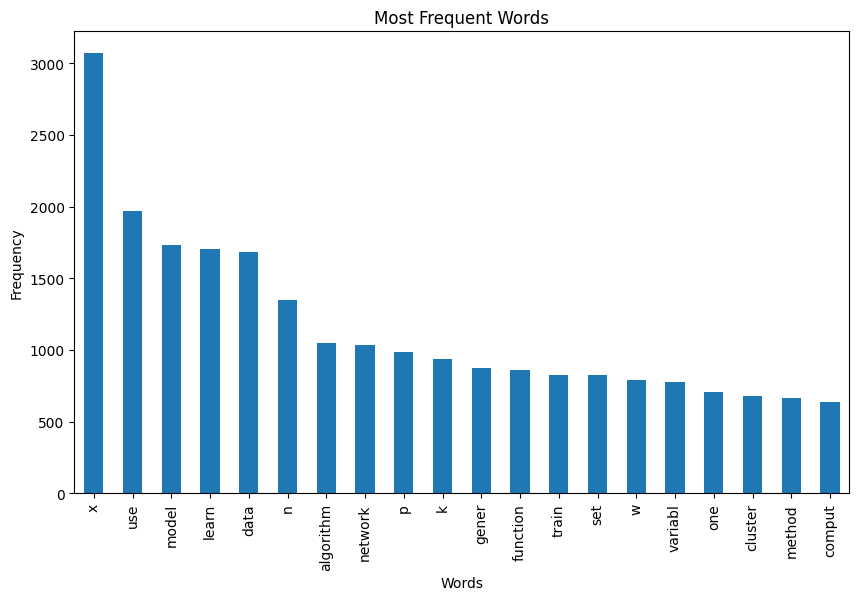

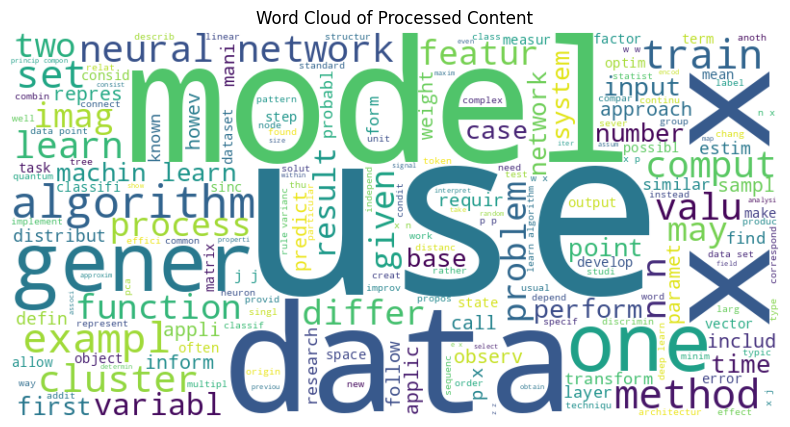

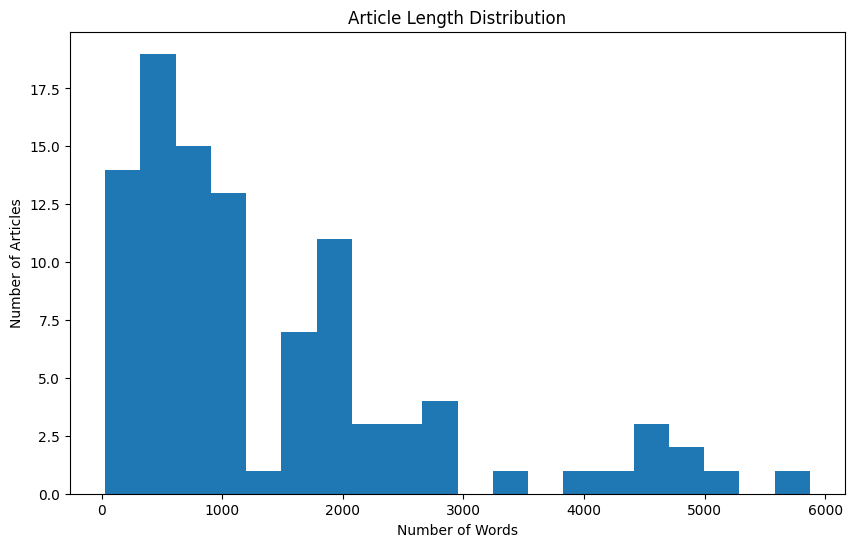

In [51]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Most Frequent Words
def plot_most_frequent_words(df, top_n=20):
    all_words = ' '.join(df['processedContent']).split()
    word_counts = pd.Series(all_words).value_counts().head(top_n)
    word_counts.plot(kind='bar', figsize=(10, 6), title='Most Frequent Words')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.show()

# Word Cloud
def plot_word_cloud(df):
    all_words = ' '.join(df['processedContent'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Processed Content')
    plt.show()

# Article Length Distribution
def plot_article_length_distribution(df):
    article_lengths = df['processedContent'].apply(lambda x: len(x.split()))
    article_lengths.plot(kind='hist', bins=20, figsize=(10, 6), title='Article Length Distribution')
    plt.xlabel('Number of Words')
    plt.ylabel('Number of Articles')
    plt.show()

# Generate statistics
plot_most_frequent_words(df)
plot_word_cloud(df)
plot_article_length_distribution(df)


# Testing

In [53]:
history = ['Machine learning', 'Extraterrestrial life', 'Adolf Hitler']
recommendations = recommendArticles(history, df, top_n=5)
recommendations

,title,link,similarity,explanation
0,Führer,https://en.wikipedia.org/wiki/F%C3%BChrer_of_Germany,0.469586,"abolish, absolut, accord, achiev, act"
1,Life,https://en.wikipedia.org/wiki/Life,0.353557,"abandon, abil, abl, abolish, absenc"
2,Paul von Hindenburg,https://en.wikipedia.org/wiki/Paul_von_Hindenburg,0.346636,"abandon, abl, abolish, absolut, abus"
3,President of Germany (1919–1945),https://en.wikipedia.org/wiki/President_of_Germany_(1919%E2%80%931945),0.301894,"abl, absolut, act, action, adolf"
4,Abiogenesis,https://en.wikipedia.org/wiki/Abiogenesis,0.296279,"abil, abiogen, abiogenesi, abl, absenc"


In [42]:
history = ['Machine learning']
recommendations = recommendArticles(history, df, top_n=5)
recommendations

,title,link,similarity
0,Deep learning,https://en.wikipedia.org/wiki/Deep_learning,0.529736
1,Neural network (machine learning),https://en.wikipedia.org/wiki/Artificial_neural_network,0.528905
2,Meta-learning (computer science),https://en.wikipedia.org/wiki/Meta-learning_(computer_science),0.521394
3,Self-supervised learning,https://en.wikipedia.org/wiki/Self-supervised_learning,0.492130
4,Feature learning,https://en.wikipedia.org/wiki/Feature_learning,0.489661


In [43]:
history = ['Machine learning']
recommendations = recommendArticles(history, df, top_n=5)
recommendations

,title,link,similarity
0,Deep learning,https://en.wikipedia.org/wiki/Deep_learning,0.529736
1,Neural network (machine learning),https://en.wikipedia.org/wiki/Artificial_neural_network,0.528905
2,Meta-learning (computer science),https://en.wikipedia.org/wiki/Meta-learning_(computer_science),0.521394
3,Self-supervised learning,https://en.wikipedia.org/wiki/Self-supervised_learning,0.492130
4,Feature learning,https://en.wikipedia.org/wiki/Feature_learning,0.489661


In [44]:
history = ['Machine learning', 'Memtransistor', 'Train', 'Germany']
recommendations = recommendArticles(history, df, top_n=5)
recommendations

,title,link,similarity
0,West Germany,https://en.wikipedia.org/wiki/West_Germany,0.615893
1,Rail transport,https://en.wikipedia.org/wiki/Rail_transport,0.437761
2,German language,https://en.wikipedia.org/wiki/German_language,0.429508
3,Flag of Germany,https://en.wikipedia.org/wiki/Flag_of_Germany,0.356223
4,Deep learning,https://en.wikipedia.org/wiki/Deep_learning,0.309938


In [45]:
history = ['Memtransistor', 'Train', 'Germany', 'Machine learning']
recommendations = recommendArticles(history, df, top_n=5)
recommendations

,title,link,similarity
0,West Germany,https://en.wikipedia.org/wiki/West_Germany,0.615893
1,Rail transport,https://en.wikipedia.org/wiki/Rail_transport,0.437761
2,German language,https://en.wikipedia.org/wiki/German_language,0.429508
3,Flag of Germany,https://en.wikipedia.org/wiki/Flag_of_Germany,0.356223
4,Deep learning,https://en.wikipedia.org/wiki/Deep_learning,0.309938


In [46]:
history = ['Mountain pigeon']
recommendations = recommendArticles(history, df, top_n=5)
recommendations

,title,link,similarity
0,Papuan mountain pigeon,https://en.wikipedia.org/wiki/Papuan_mountain_pigeon,0.845961
1,Taxonomy (biology),https://en.wikipedia.org/wiki/Taxonomy_(biology),0.056489
2,Animal,https://en.wikipedia.org/wiki/Animal,0.047039
3,Naive Bayes classifier,https://en.wikipedia.org/wiki/Naive_Bayes_classifier,0.046796
4,Random forest,https://en.wikipedia.org/wiki/Random_forest,0.044260


In [47]:
history = ['Papuan mountain pigeon']
recommendations = recommendArticles(history, df, top_n=5)
recommendations

,title,link,similarity
0,Least-concern species,https://en.wikipedia.org/wiki/Least_Concern,0.152738
1,IUCN Red List,https://en.wikipedia.org/wiki/IUCN_Red_List,0.150306
2,Conservation status,https://en.wikipedia.org/wiki/Conservation_status,0.141665
3,Random forest,https://en.wikipedia.org/wiki/Random_forest,0.078186
4,Naive Bayes classifier,https://en.wikipedia.org/wiki/Naive_Bayes_classifier,0.073148


In [48]:
df

,title,link,content,processedContent
0,Machine learning,https://en.wikipedia.org/wiki/Machine_learning,Machine learning (ML) is a field of study in a...,machin learn ml field studi artifici intellig ...
1,Machine Learning (journal),https://en.wikipedia.org/wiki/Machine_Learning...,Machine Learning is a peer-reviewed scientifi...,machin learn scientif journal publish sinc for...
2,Statistical learning in language acquisition,https://en.wikipedia.org/wiki/Statistical_lear...,Statistical learning is the ability for humans...,statist learn abil human anim extract statist ...
3,Data mining,https://en.wikipedia.org/wiki/Data_mining,Data mining is the process of extracting and d...,data mine process extract discov pattern larg ...
4,Supervised learning,https://en.wikipedia.org/wiki/Supervised_learning,"In machine learning, supervised learning (SL) ...",machin learn supervis learn sl paradigm model ...
...,...,...,...,...
95,Mamba (deep learning architecture),https://en.wikipedia.org/wiki/Mamba_(deep_lear...,Mamba[a] is a deep learning architecture focus...,mamba deep learn architectur focus sequenc mod...
96,Spiking neural network,https://en.wikipedia.org/wiki/Spiking_neural_n...,Spiking neural networks (SNNs) are artificial ...,spike neural network snn artifici neural netwo...
97,Memtransistor,https://en.wikipedia.org/wiki/Memtransistor,The memtransistor (a blend word from Memory Tr...,memtransistor blend word memori transfer resis...
98,Electrochemical RAM,https://en.wikipedia.org/wiki/Electrochemical_RAM,Electrochemical Random-Access Memory (ECRAM) i...,electrochem memori ecram type memori nvm multi...
